In [25]:
from emd_analysis_functions import *

In [20]:
# Load the HPC data from the trials during the OS task. In the 'HPC' column you will find the amplitude on each nth sample
t1 = scipy.io.loadmat('/Users/adrianbontje/Desktop/thesiski/analysis/t1/HPC_100_CH4_0.continuous.mat')['HPC']
t2 = scipy.io.loadmat('/Users/adrianbontje/Desktop/thesiski/analysis/t2/HPC_100_CH4_0.continuous.mat')['HPC']
t3 = scipy.io.loadmat('/Users/adrianbontje/Desktop/thesiski/analysis/t3/HPC_100_CH4_0.continuous.mat')['HPC']
t4 = scipy.io.loadmat('/Users/adrianbontje/Desktop/thesiski/analysis/t4/HPC_100_CH4_0.continuous.mat')['HPC']
t5 = scipy.io.loadmat('/Users/adrianbontje/Desktop/thesiski/analysis/t5/HPC_100_CH4_0.continuous.mat')['HPC']
t6 = scipy.io.loadmat('/Users/adrianbontje/Desktop/thesiski/analysis/t6/HPC_100_CH4_0.continuous.mat')['HPC']

srate = 1000
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 25, 24*10, 'linear')

# Generated signals
data_length=30 #time in seconds",
npnts = srate*data_length #number of points to generate,
t  = np.arange(0,npnts)/srate #time vector
nonmodulatedamplitude=2; # increase this to get less modulation (lower MI value),
Phase_Modulating_Freq=8
Amp_Modulated_Freq=80
# fp is the theta/phase frequency
# fa is the gamma/amplitude frequency                         X
A_fa=(0.2*(np.sin(2*np.pi*t*Phase_Modulating_Freq)+1)+nonmodulatedamplitude*0.1)
A_fpmax= 1 #Maximal amplitude of fp   
lfp=A_fa*np.sin(2*np.pi*t*Amp_Modulated_Freq)+(A_fpmax*np.sin(2*np.pi*t*Phase_Modulating_Freq))
generated_lfps = []

for _ in range(5):
    gauss=np.random.randn(1,len(lfp))#gaussian noise
    lfp= np.add(lfp,gauss[0])
    generated_lfps.append(lfp)

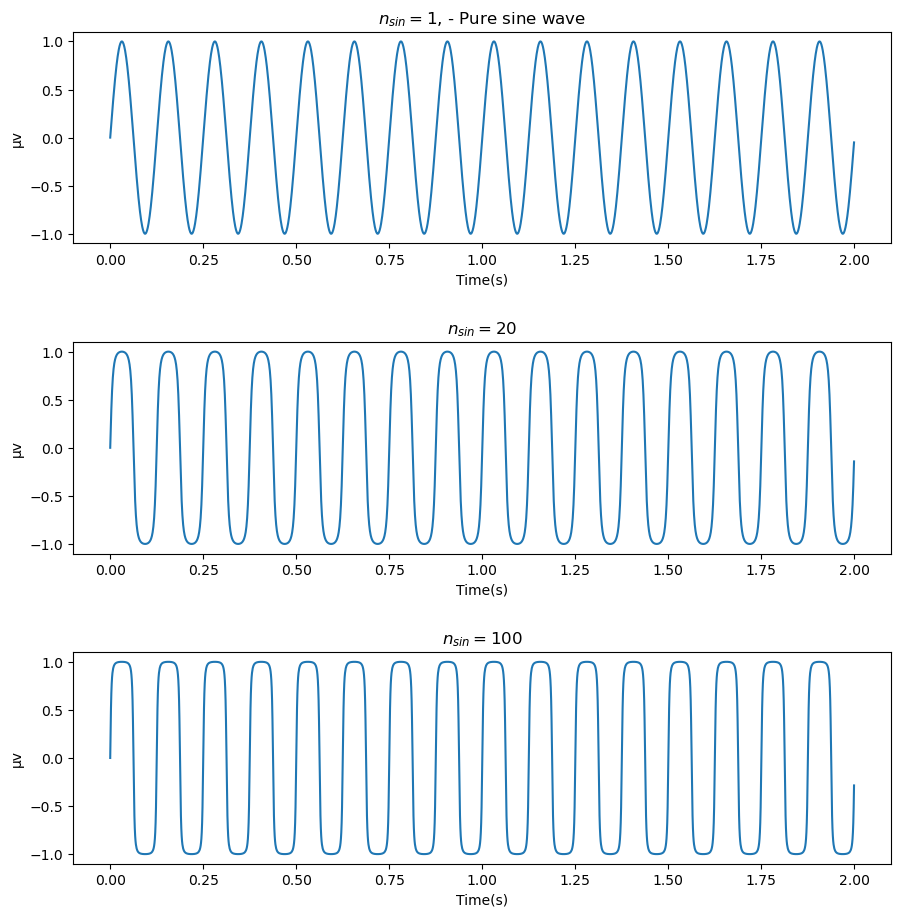

In [59]:
# Plots to show influence of iterated sine function (increasing FD)
fig54, axs54 = plt.subplots(3,1, figsize=(10,10))
fig54.tight_layout(pad=5)
theta_s = np.sin(2*np.pi*t[:2*srate]*Phase_Modulating_Freq)
theta_ns20 = np.sin(2*np.pi*t[:2*srate]*Phase_Modulating_Freq)

for i in range(20):
    theta_ns20 = np.sin(theta_ns20)
theta_ns100 = theta_ns20
theta_ns20 = theta_ns20 / np.max(theta_ns20)
for i in range(80):
    theta_ns100 = np.sin(theta_ns100)
theta_ns100 = theta_ns100 / np.max(theta_ns100)
axs54[0].plot(t[:2*srate],theta_s)
axs54[1].plot(t[:2*srate],theta_ns20)
axs54[2].plot(t[:2*srate],theta_ns100)
axs54[0].set_title('$n_{sin} = 1$, - Pure sine wave')
axs54[0].set_xlabel('Time(s)')
axs54[1].set_xlabel('Time(s)')
axs54[2].set_xlabel('Time(s)')
axs54[0].set_ylabel('\u03BCv')
axs54[1].set_ylabel('\u03BCv')
axs54[2].set_ylabel('\u03BCv')

axs54[1].set_title('$n_{sin} = 20$')
axs54[2].set_title('$n_{sin} = 100$')
plt.show()

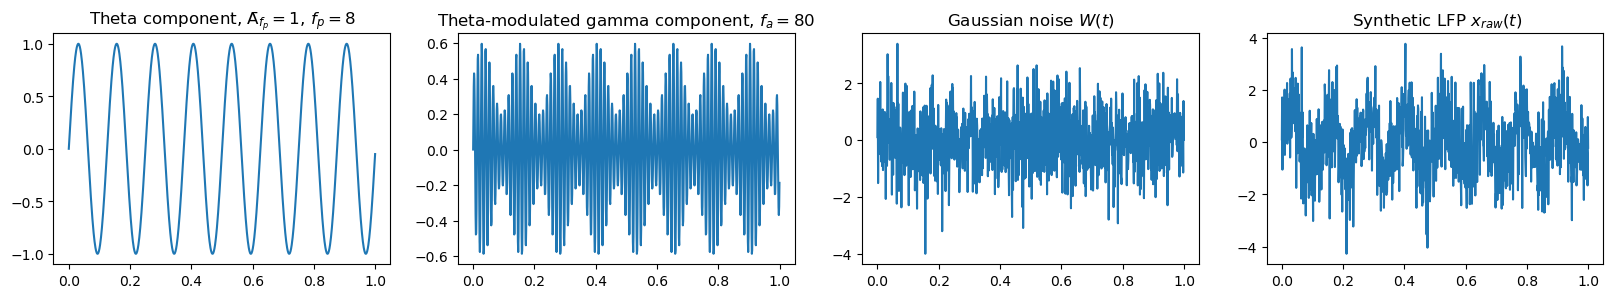

In [57]:
# Plots that show the components of the synthetic LFP signal
theta_modulated_gamma = A_fa*np.sin(2*np.pi*t*Amp_Modulated_Freq)
theta = A_fpmax*np.sin(2*np.pi*t*Phase_Modulating_Freq)
whitenoise = np.random.randn(1,len(lfp))#gaussian noise
fig1000, axs1000 = plt.subplots(1,4, figsize=(20,3))
axs1000[0].plot(t[:srate], theta[:srate])
axs1000[0].set_title('Theta component, A'+ u'\u0304' + '$_{f_{p}} = 1$, $f_p = 8$')
axs1000[1].plot(t[:srate], theta_modulated_gamma[:srate])
axs1000[1].set_title('Theta-modulated gamma component, $f_a = 80$')
axs1000[2].plot(t[:srate], whitenoise[0][:srate])
axs1000[2].set_title('Gaussian noise $W(t)$')
rawlfp = theta[:srate] + theta_modulated_gamma[:srate] + whitenoise[0][:srate]
axs1000[3].plot(t[:srate], rawlfp)
axs1000[3].set_title(' Synthetic LFP $x_{raw}(t)$')
plt.show()



In [21]:
# EMD sifting configurations
#Method #1: iterated mask default settings
itmaskconfig = emd.sift.get_config('iterated_mask_sift')
itmaskconfig['max_imfs'] = 8
itmaskconfig['sample_rate'] = srate
itmaskconfig['ret_mask_freq'] = True
itmask = partial(emd.sift.iterated_mask_sift, **itmaskconfig)
itmaskconfig['max_imfs'] = 7
itmask_gen = partial(emd.sift.iterated_mask_sift, **itmaskconfig)

# Method #2: mask sift with mask frequency based on amplitude-weighted mean IF of first IMF from regular sifting. 
ifmaskconfig = emd.sift.get_config('mask_sift')
ifmaskconfig['mask_freqs'] = 'if'
ifmaskconfig['max_imfs'] = 8
# To compare the masks used
ifmaskconfig['ret_mask_freq'] = True
# the function ifmask will run a masked sift on a signal x, with the mask frequency based on IF of first IMF.
# should return the IMFs and the mask frequencies used
ifmask = partial(emd.sift.mask_sift, **ifmaskconfig)
ifmaskconfig['max_imfs'] = 7
ifmask_gen = partial(emd.sift.mask_sift, **ifmaskconfig)

# Method #3: mask sift with mask frequency based on the amount of zero crossings of first IMF through 'regular' sifting. 
zcmaskconfig = emd.sift.get_config('mask_sift')
zcmaskconfig['max_imfs'] = 8
zcmaskconfig['ret_mask_freq'] = True
# the function zcmask will run a masked sift on a signal x, with the mask frequency based on the amount of zero crossings of first IMF.
# should return the IMFs and the mask frequencies used
zcmask = partial(emd.sift.mask_sift, **zcmaskconfig)
zcmaskconfig['max_imfs'] = 7
zcmask_gen = partial(emd.sift.mask_sift, **zcmaskconfig)

#Method #4: iterated mask IF
itmaskifconfig = emd.sift.get_config('iterated_mask_sift')
itmaskifconfig['max_imfs'] = 8
itmaskifconfig['sample_rate'] = srate
itmaskifconfig['ret_mask_freq'] = True
itmaskifconfig['mask_0'] = 'if'
itmaskif = partial(emd.sift.iterated_mask_sift, **itmaskifconfig)
itmaskifconfig['max_imfs'] = 7
itmaskif_gen = partial(emd.sift.iterated_mask_sift, **itmaskifconfig)

# Method #5: Ensemble sift with 24 ensembles
# imf4 = emd.sift.ensemble_sift(lfp, max_imfs=10, nensembles=24, nprocesses=6, ensemble_noise=1)
ensembleconfig = emd.sift.get_config('ensemble_sift')
ensembleconfig['nensembles'] = 24
ensembleconfig['max_imfs'] = 8
ensembleconfig['nprocesses'] = 6
ensembleconfig['ensemble_noise'] = 1
ensemble = partial(emd.sift.ensemble_sift, **ensembleconfig)
ensembleconfig['max_imfs'] = 7
ensemble_gen = partial(emd.sift.ensemble_sift, **ensembleconfig)


method_names = ['Iterated mask ZC EMD', 'Masked IF EMD', 'Masked ZC EMD', 'Iterated mask IF EMD', 'Ensemble EMD']


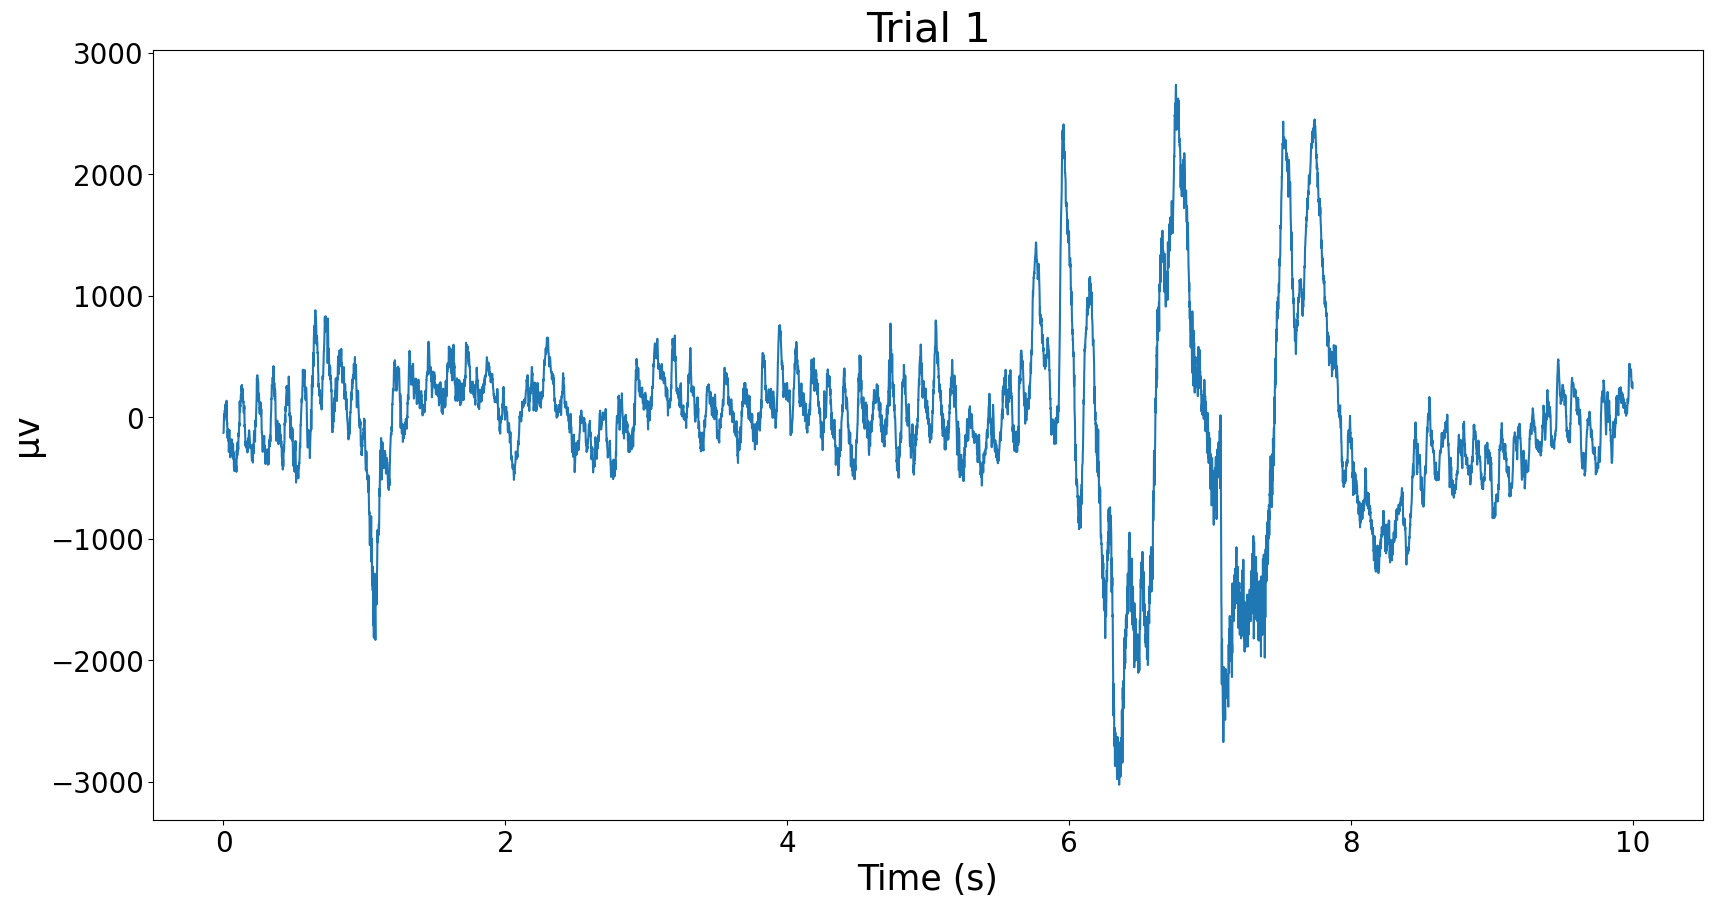

In [114]:
#Plot for ten seconds of a trial
fig199,axs199 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.linspace(0,10*srate-1, 10*srate)/srate, t1[:10*srate])
axs199.set_xlabel('Time (s)',size=25)
axs199.set_ylabel('\u03BCv', size=25)
axs199.set_title('Trial 1', size=30)
axs199.xaxis.set_tick_params(labelsize=20)
axs199.yaxis.set_tick_params(labelsize=20)

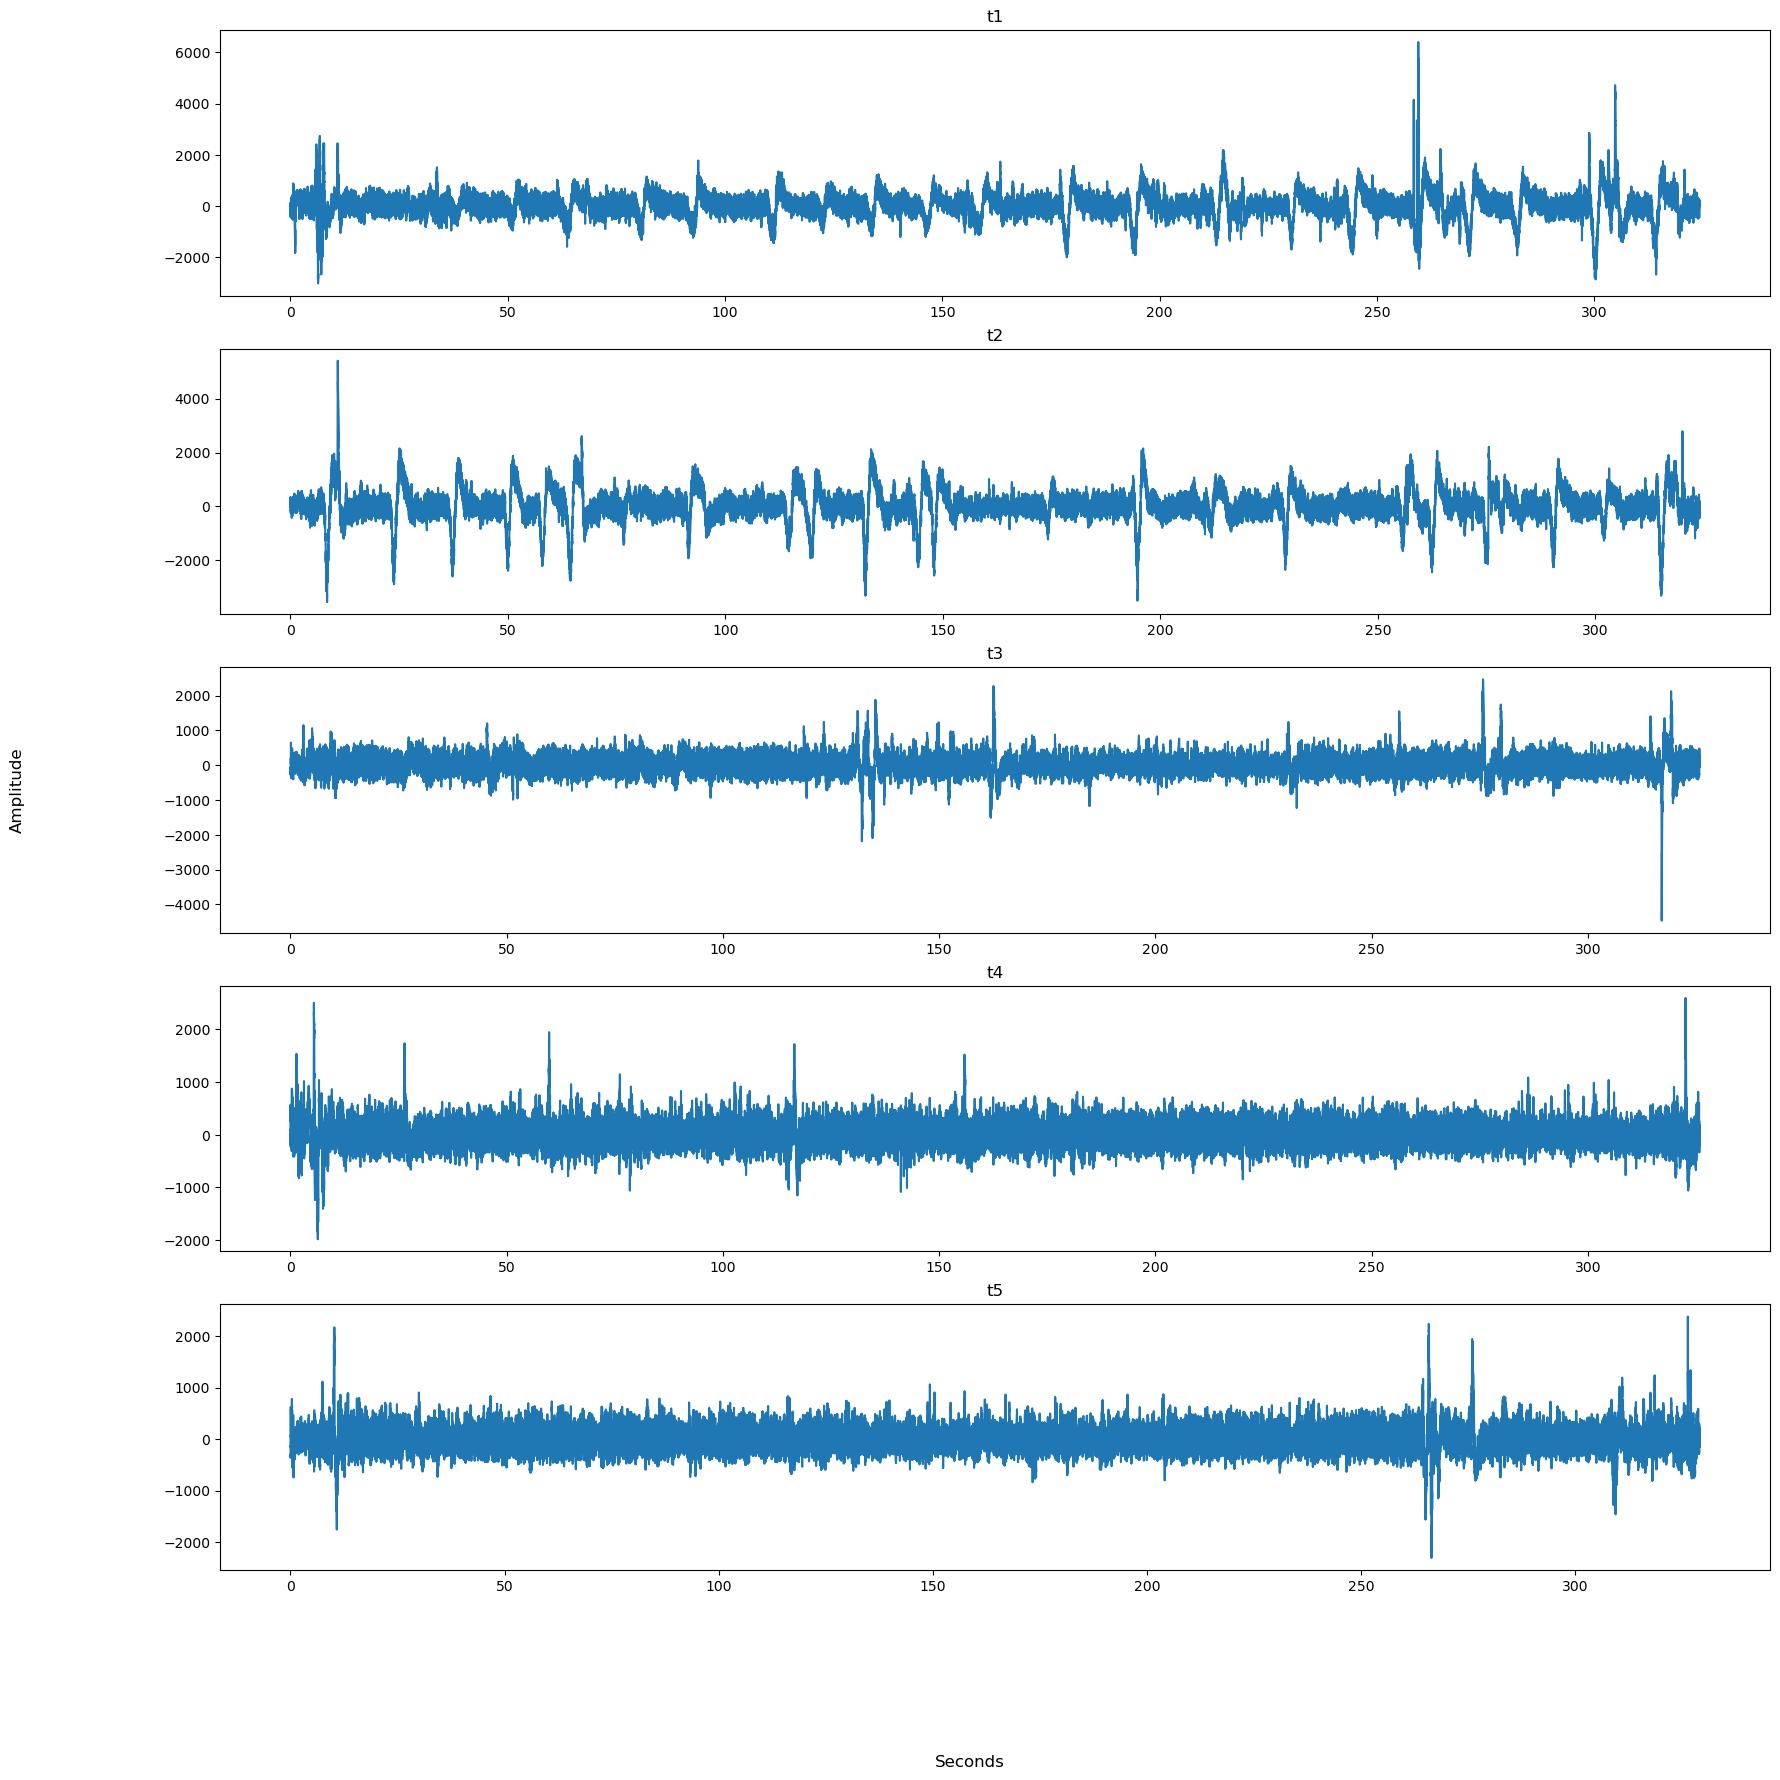

In [6]:
# Plots of the trials
fig1,axs1 = plt.subplots(5,1, figsize=(20,20))
axs1[0].plot(np.arange(0,len(t1))/srate, t1)
axs1[1].plot(np.arange(0,len(t2))/srate, t2)
axs1[2].plot(np.arange(0,len(t3))/srate, t3)
axs1[3].plot(np.arange(0,len(t4))/srate, t4)
axs1[4].plot(np.arange(0,len(t5))/srate, t5)
fig1.supxlabel('Seconds')
fig1.supylabel('Amplitude')
axs1[0].set_title('t1')
axs1[1].set_title('t2')
axs1[2].set_title('t3')
axs1[3].set_title('t4')
axs1[4].set_title('t5')
plt.show()

In [7]:
# imfs_methods, masks_methods = run_mask_methods(t1, srate, [itmask, ifmask, zcmask, itmaskif])
# imfs_methods.append(ensemble(t1))

In [23]:
# list of EMD configs for the trial data
trials_list = [t1, t2, t3, t4, t5]
maskmethods_list = [itmask, ifmask, zcmask, itmaskif]
ensemblemethods_list = [ensemble]

In [9]:
# list of EMD configs for the synthetic/generated signals
maskmethods_gen = [itmask_gen, ifmask_gen, zcmask_gen, itmaskif_gen]
ensemblemethods_gen = [ensemble_gen]

In [10]:
# run analysis on the generated signals with the EMD configs for the generated signals
selected_imfs_gen, imfs_ae_gen, selected_freqs_gen, hhts_trials_gen, pmsis_trials_gen = trials_analysis(generated_lfps, maskmethods_gen, ensemblemethods_gen, method_names, srate, freq_edges)

In [11]:
pmsis_trials_gen

array([[0.0066561 , 0.00208533, 0.02010069, 0.00634868, 0.19638293],
       [0.01228962, 0.00385823, 0.04604634, 0.01243836, 0.17674484],
       [0.01533504, 0.00567478, 0.05066446, 0.01511211, 0.1559098 ],
       [0.01825346, 0.00711015, 0.02845728, 0.01834044, 0.16034542],
       [0.02120715, 0.00930353, 0.06131689, 0.02063755, 0.15898629]])

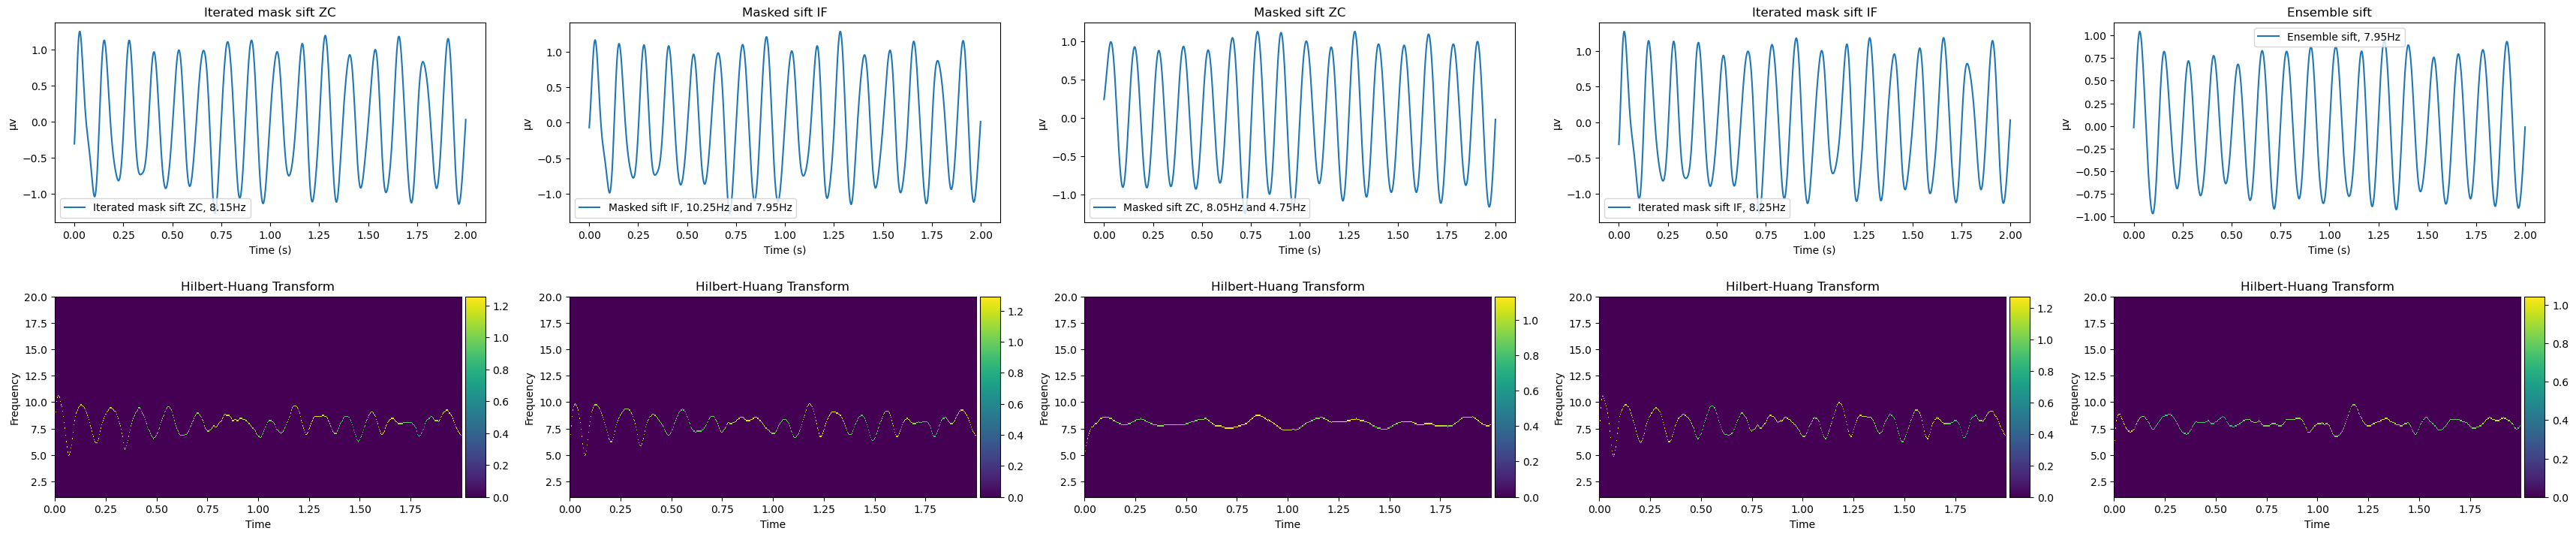

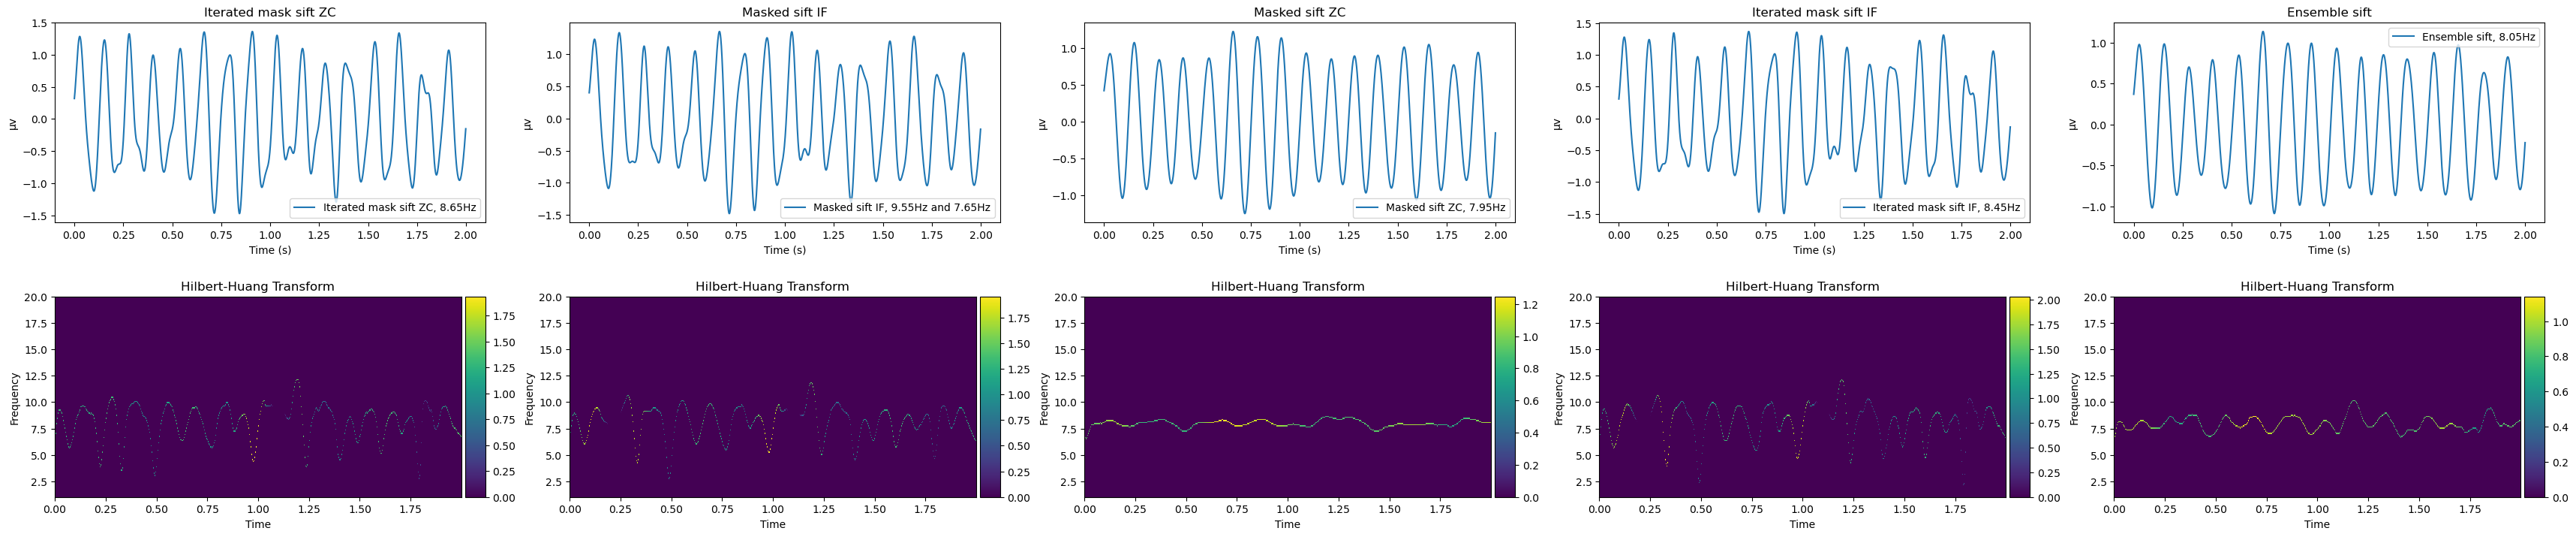

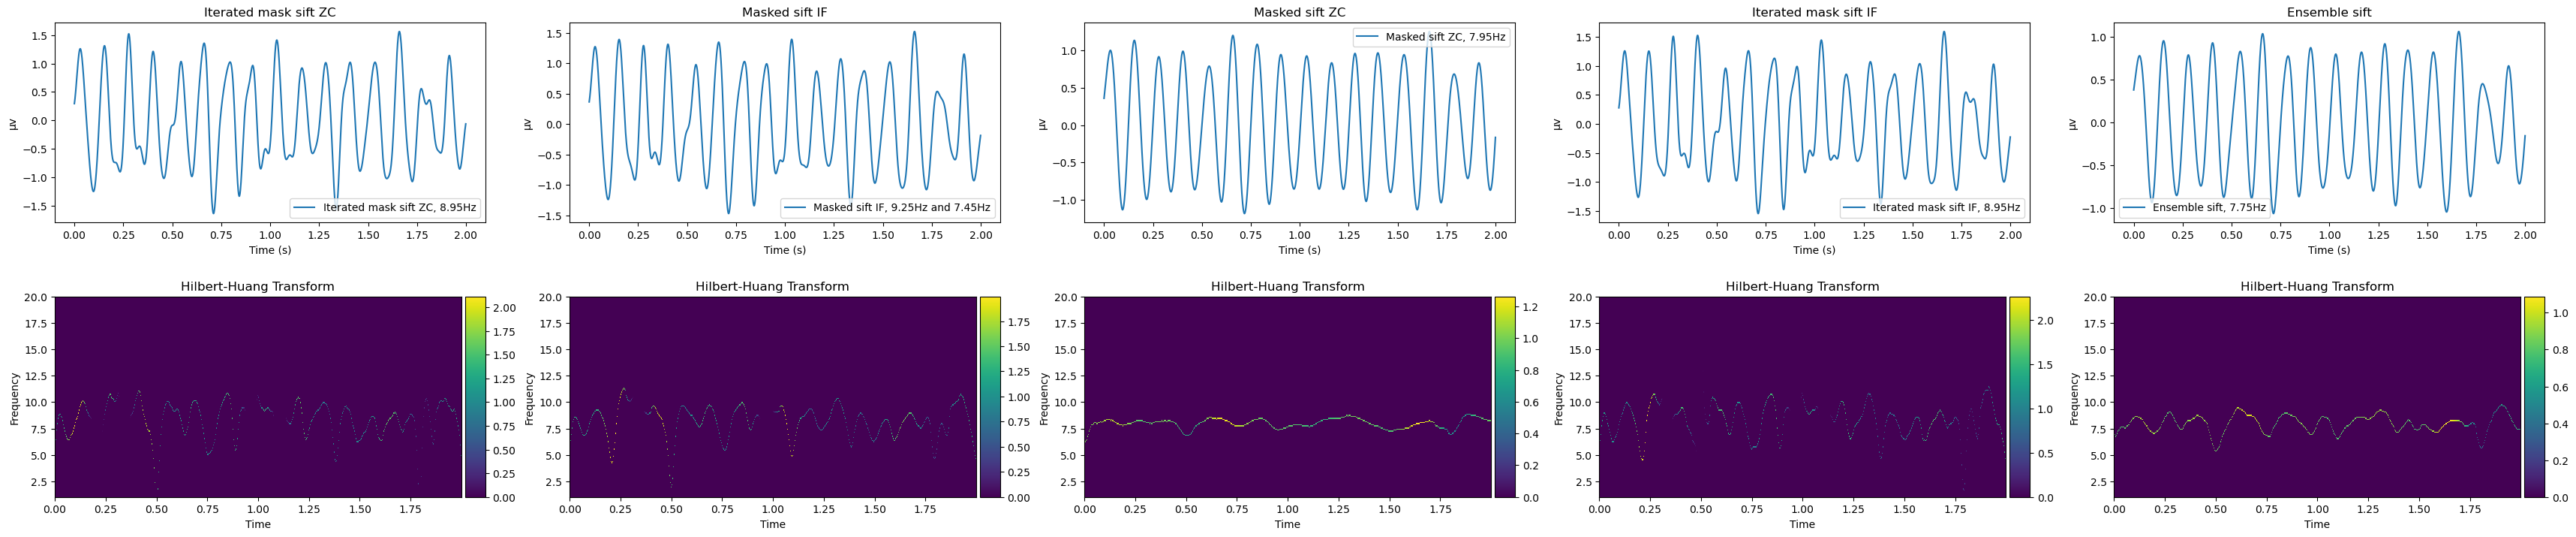

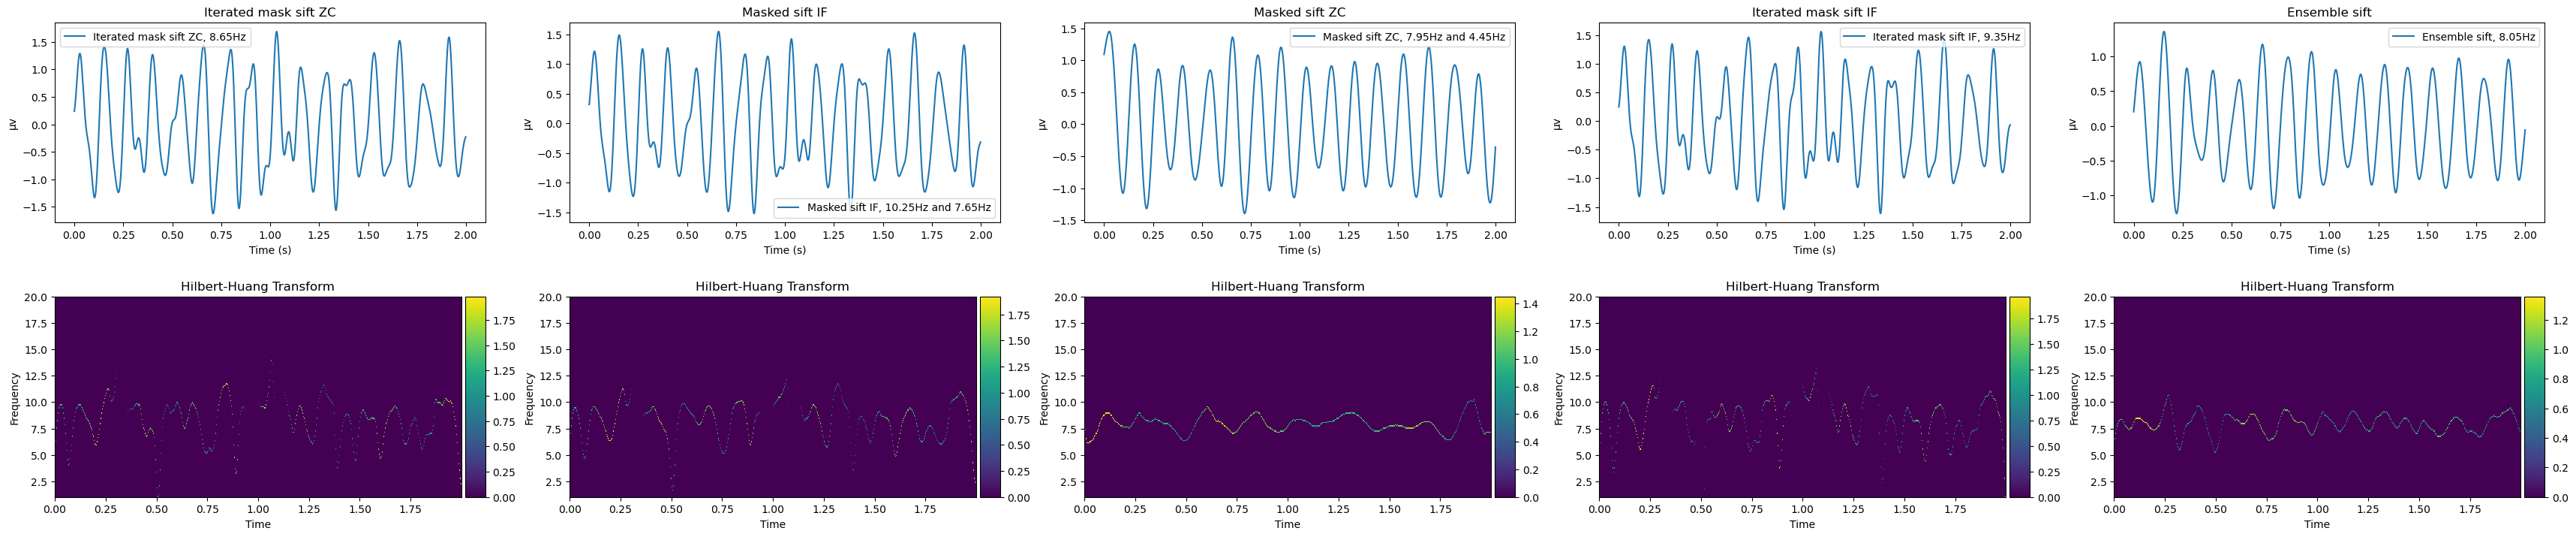

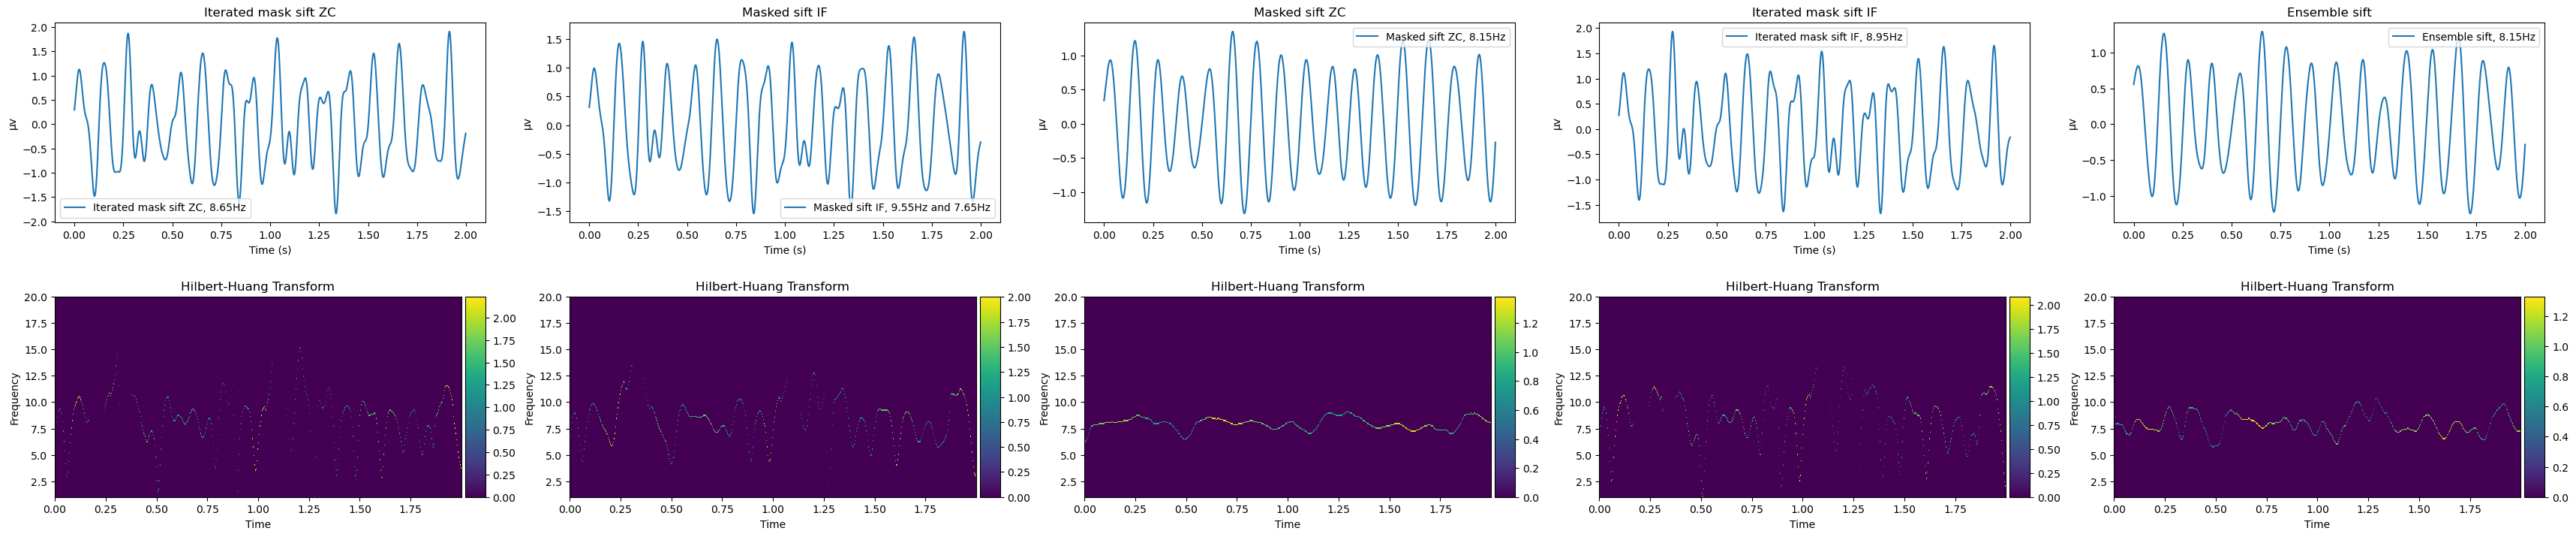

In [12]:
# Plot the resulting hhts and waveforms
for selected_imfs, selected_freqs, selected_hhts in zip(selected_imfs_gen, selected_freqs_gen, hhts_trials_gen):
    plot_wf_hht(selected_imfs, selected_freqs, selected_hhts, method_names, freq_centres, srate)

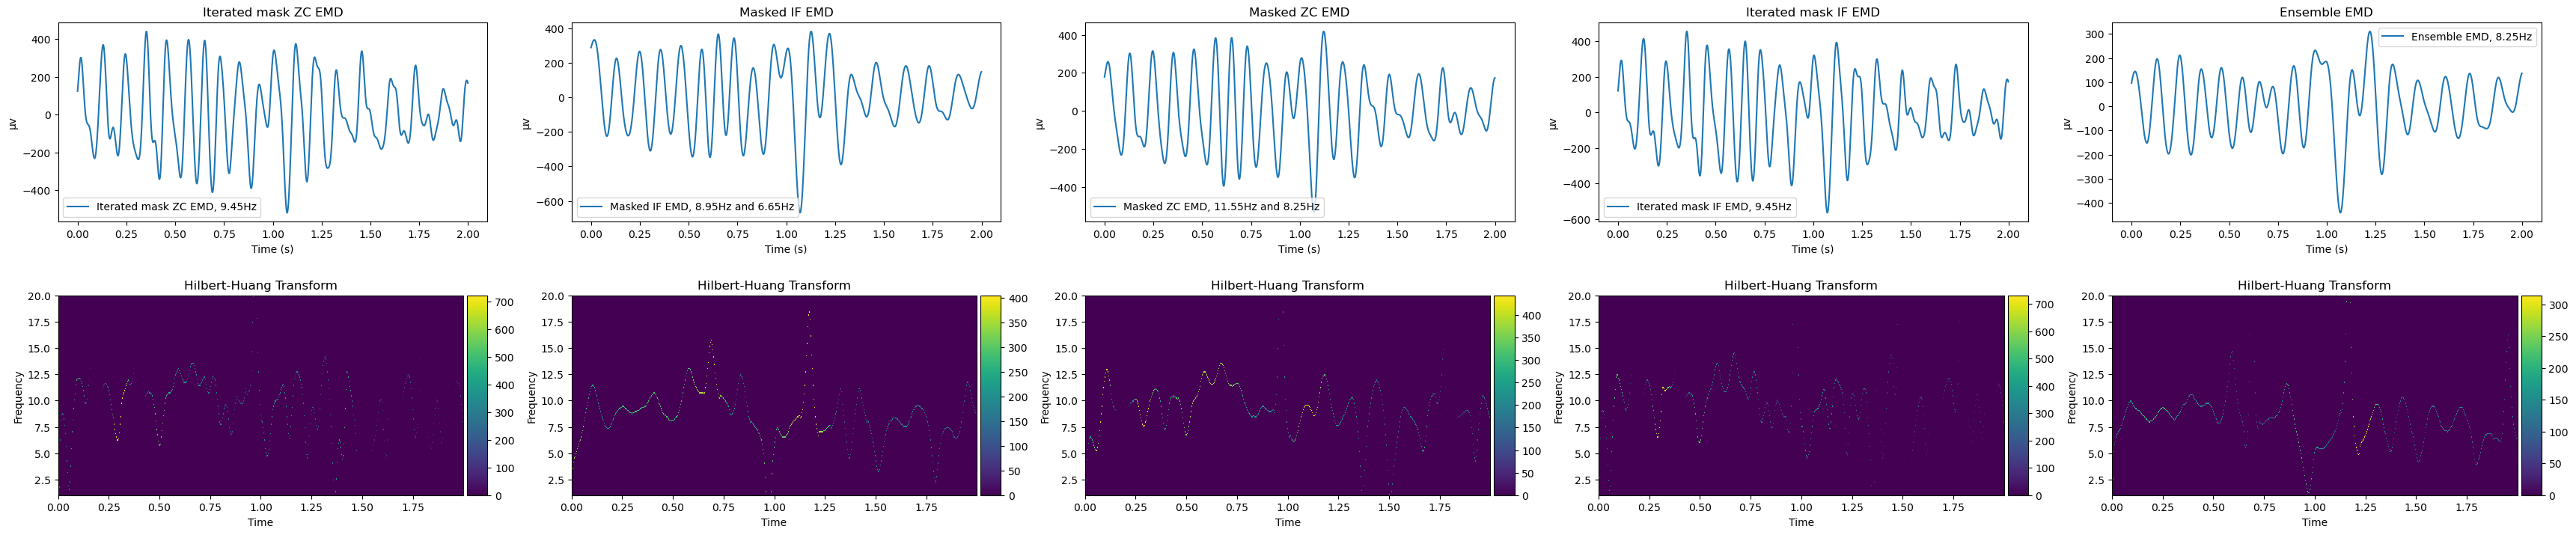

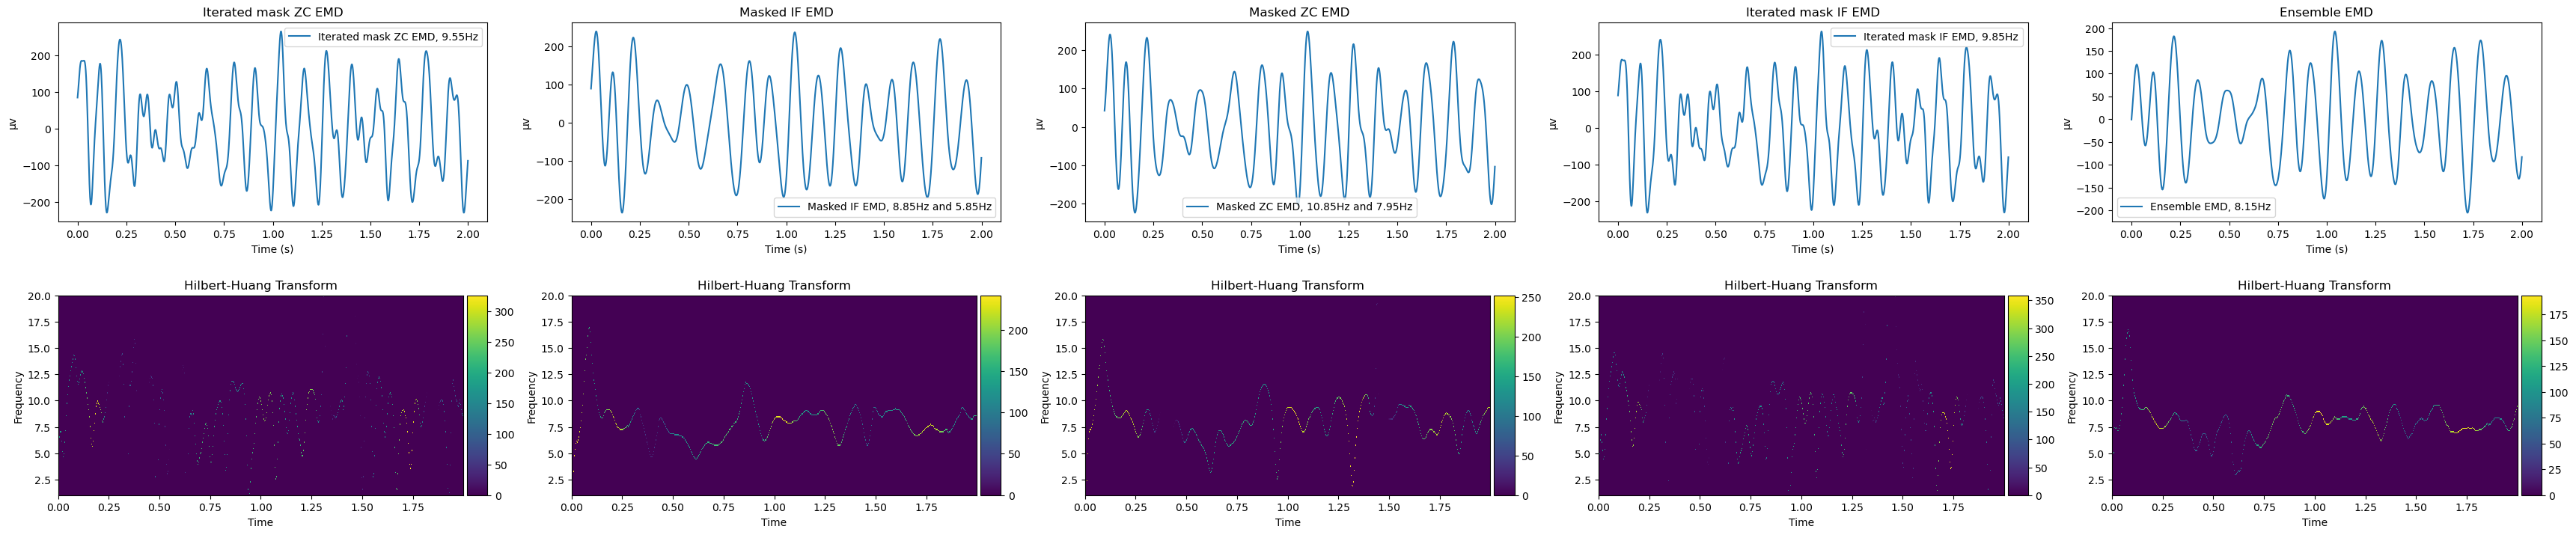

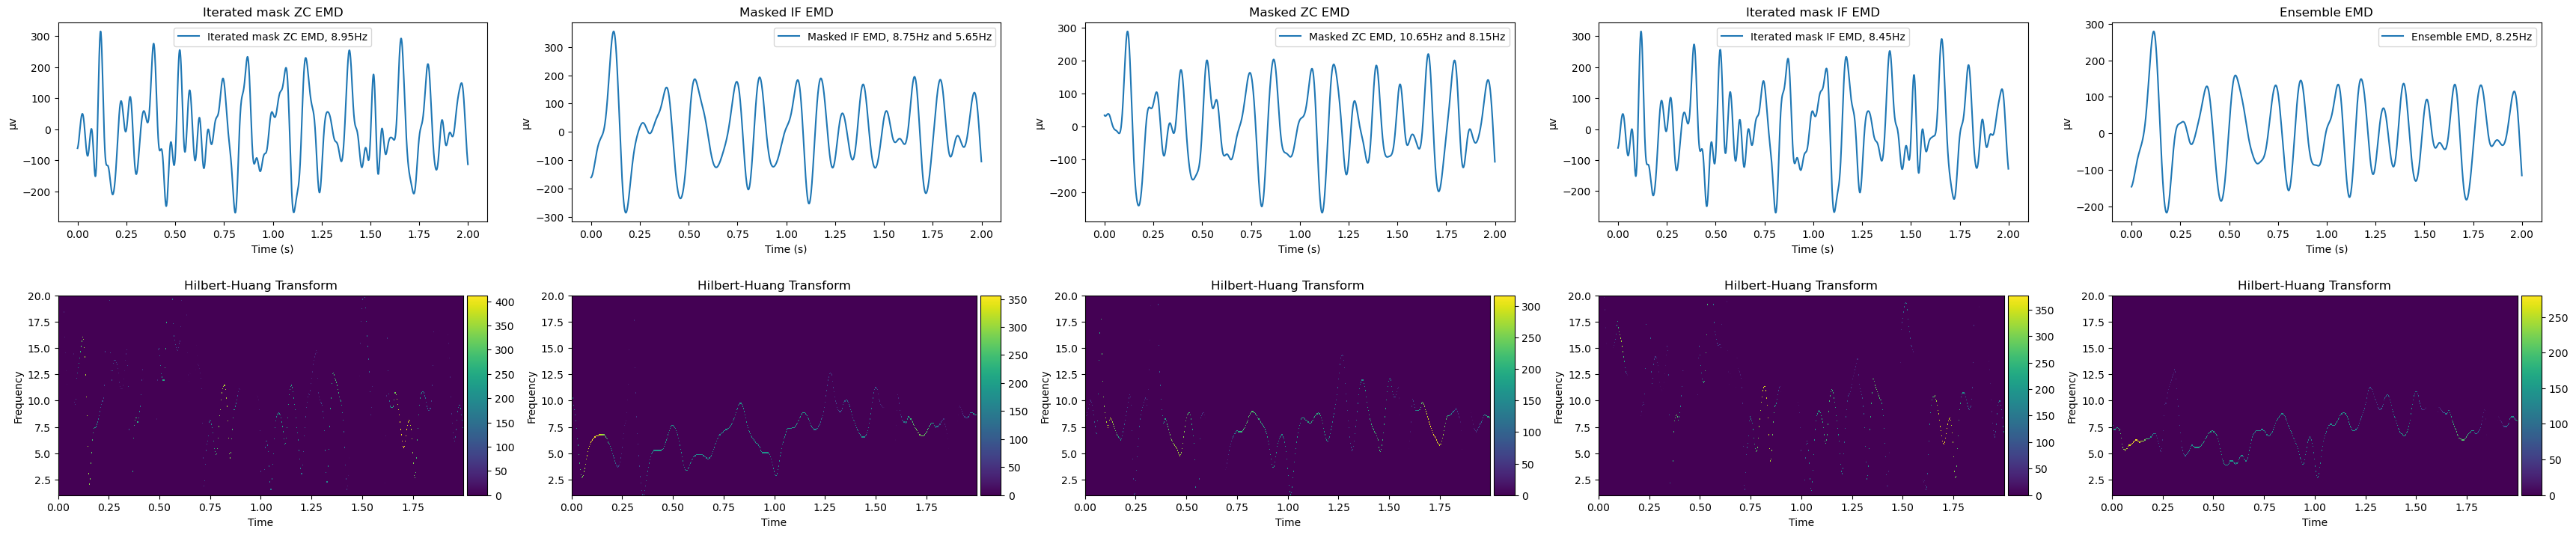

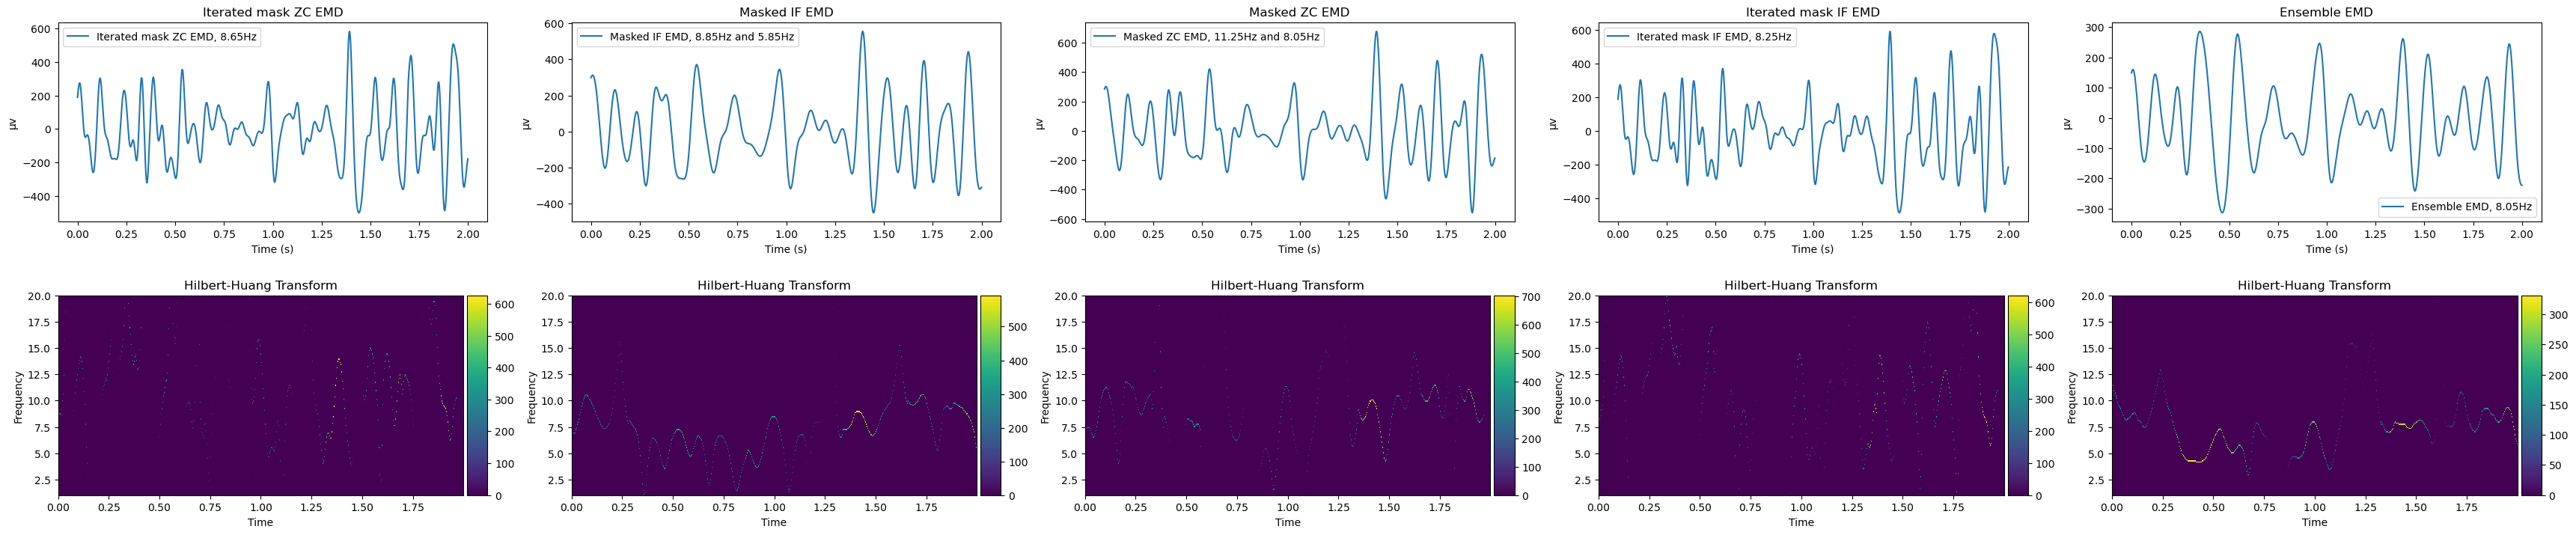

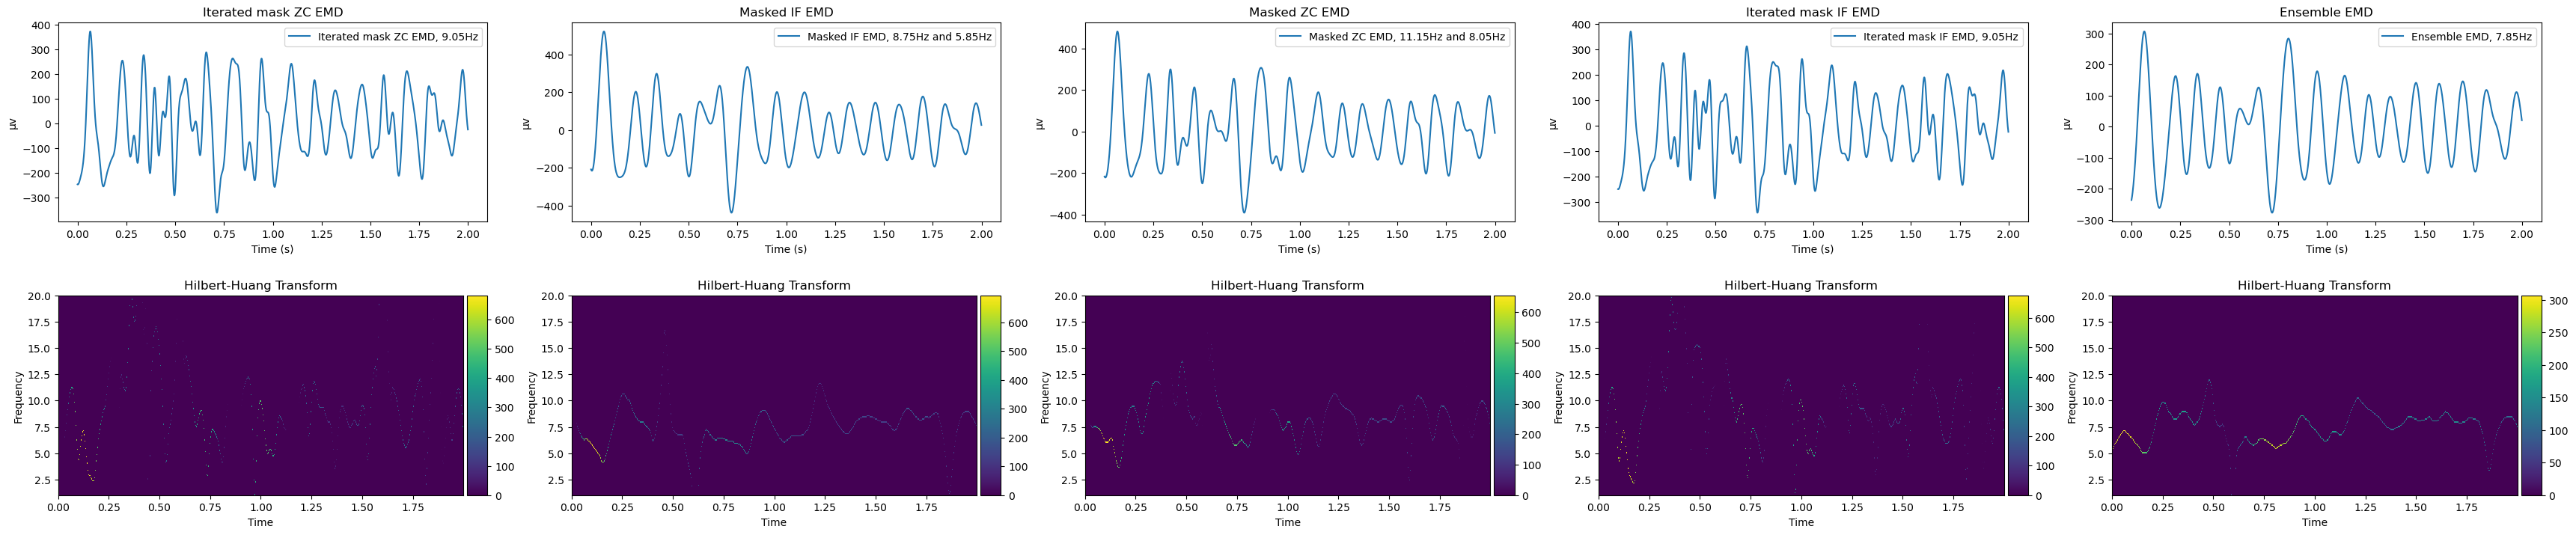

In [24]:
# On the five trials from the OS data, plot the resulting waveforms and hhts
pmsis_trials = []
for trial in trials_list:
    imfs_methods_ae, selected_imfs_all, selected_freqs_all, theta_indices_all, selected_hhts, pmsis_all = single_trial_analysis(trial, srate, maskmethods_list, ensemblemethods_list, freq_edges)
    pmsis_trials.append(pmsis_all)
    plot_wf_hht(selected_imfs_all, selected_freqs_all, selected_hhts, method_names, freq_centres, srate)

In [15]:
# The pmsi's of each method on the generated signals (each row is a trial and each column is a method)
pmsis_trials_gen

array([[0.0066561 , 0.00208533, 0.02010069, 0.00634868, 0.19638293],
       [0.01228962, 0.00385823, 0.04604634, 0.01243836, 0.17674484],
       [0.01533504, 0.00567478, 0.05066446, 0.01511211, 0.1559098 ],
       [0.01825346, 0.00711015, 0.02845728, 0.01834044, 0.16034542],
       [0.02120715, 0.00930353, 0.06131689, 0.02063755, 0.15898629]])

In [16]:
# pmsi's on the trial data
pmsis_trials

[[0.007858211149840921,
  0.16793706276712794,
  0.09824824593945712,
  0.007882528509909892,
  0.28579343689648284],
 [0.007541271031979485,
  0.09918097197791331,
  0.09271291308607339,
  0.00756882691746982,
  0.25924791859570495],
 [0.009093088026001173,
  0.12042838107975945,
  0.09890583986908967,
  0.009406239974635223,
  0.2982098424978854],
 [0.025933248787304353,
  0.13303264161844588,
  0.11466842014252614,
  0.024056732408473423,
  0.30728253721200993],
 [0.019319559851629857,
  0.11068678714344442,
  0.11806282982151424,
  0.022607560459796783,
  0.29112289885154935]]

In [8]:
#mean of the pmsis on trial data (5 trials)
np.nanmean(pmsis_trials, axis=0)

array([0.01394908, 0.04859585, 0.04445532, 0.01430438, 0.28859822])

In [9]:
#std of the pmsis on trial data (5 trials)
np.nanstd(pmsis_trials, axis=0)

array([0.00740543, 0.00572553, 0.00652496, 0.00741149, 0.01740637])

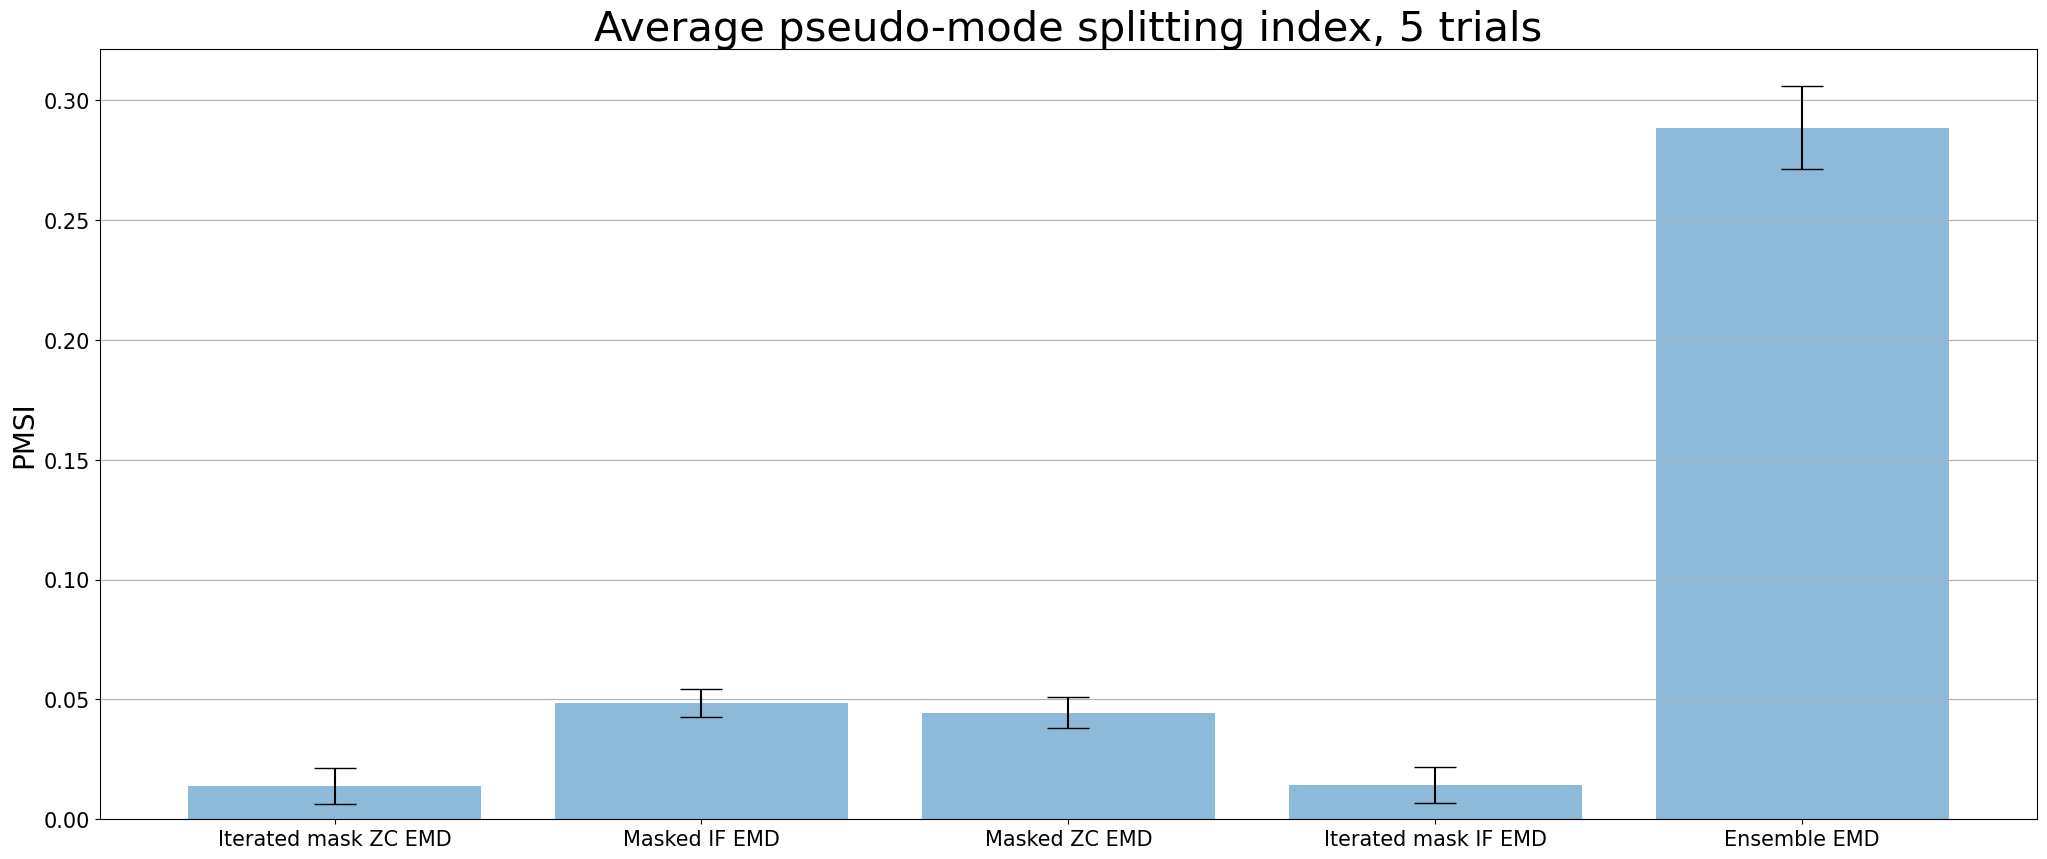

In [7]:
# PMSI on trial data
plot_pmsi(pmsis_trials, method_names, 'Average pseudo-mode splitting index, 5 trials')